In [3]:
import json, pickle
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit.primitives import BackendEstimator
from qiskit_ibm_runtime import Estimator as RuntimeEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima, FakeSherbrooke, FakeLimaV2
from qiskit import QuantumCircuit, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeBelem

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, random_clifford_circuit
from gnn import ExpValCircuitGraphModel
from qiskit.quantum_info import Clifford
from qiskit_aer.noise import depolarizing_error, coherent_unitary_error, NoiseModel
from noise_utils import AddNoise

from functools import partial

from zne import zne, ZNEStrategy
from zne.noise_amplification import *
from zne.extrapolation import *

In [4]:
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()

In [5]:
real_backend = provider.get_backend('ibm_sherbrooke')

In [6]:
fake_backend = FakeSherbrooke() #FakeLima()

## Local
fake_backend_ideal = QasmSimulator() # Noiseless
fake_backend_noisy = AerSimulator.from_backend(fake_backend) # Noisy
stabilizer_simulator = AerSimulator(method='stabilizer')

fake_run_config_ideal = {'shots': 10000, 'backend': fake_backend_ideal, 'name': 'fake_ideal'}
fake_run_config_noisy = {'shots': 10000, 'backend': fake_backend_noisy, 'name': 'fake_noisy'}

In [7]:
from qiskit.circuit import Parameter

class IsingModel:

    class Options(dict):
        def __init__(self, *args, **kwargs):
            super().__init__()
            self['nq'] = 4
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4
            self['depth'] = 15
            self.update(*args, **kwargs)

        def config_4q_paper(self):
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_100q_paper(self):
            self['nq'] = 100
            self['h'] = np.pi
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_6q_paper(self):
            self['nq'] = 6
            self['h'] = np.pi
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_10q_paper(self):
            self['h'] = 1
            self['J'] = 0.5236
            self['dt'] = 1/4

    @classmethod
    def apply_quantum_circuit_layer(cls, qc: QuantumCircuit, ops: 'IsingModel.Options'):
        allq = list(range(ops['nq']))

        qc.rx(2*ops['h']*ops['dt'], allq)

        qc.barrier()
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[1::2])
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)

        qc.barrier()
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[2:-1:2])
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.barrier()

    @classmethod
    def make_quantum_circuit(cls, ops: 'IsingModel.Options'):
        qc = QuantumCircuit(ops['nq'])
        allq = list(range(ops['nq']))

        for step in range(ops['depth']):
            cls.apply_quantum_circuit_layer(qc, ops)

        if ops['measure_basis'] == 'Z':
            pass
        elif  ops['measure_basis'] == 'X':
            qc.h(allq)
        elif  ops['measure_basis'] == 'Y':
            qc.sdg(allq)
            qc.h(allq)
        else:
            raise Exception("Must be X Y or Z")
        qc.measure_all()

        return qc

    @classmethod
    def make_circs_sweep(cls, ops, num_steps, measure_basis):
        ops['measure_basis'] = measure_basis
        ops['depth'] = num_steps
        qc = cls.make_quantum_circuit(ops)
        qc.metadata = {}
        qc.metadata['measure_basis'] = measure_basis
        qc.metadata['depth'] = num_steps
        return qc

In [8]:
sherbrooke_layout = list(range(113, 127)) + [112] + list(range(108, 93, -1)) + [90] + list(range(75, 90)) + [74] + list(range(70, 55, -1)) + [52] + list(range(37, 52)) + [36, 32, 31, 30, 17] + list(range(12, 3, -1)) + [15, 22, 23, 24, 25, 26, 27, 28]

print(len(sherbrooke_layout))

100


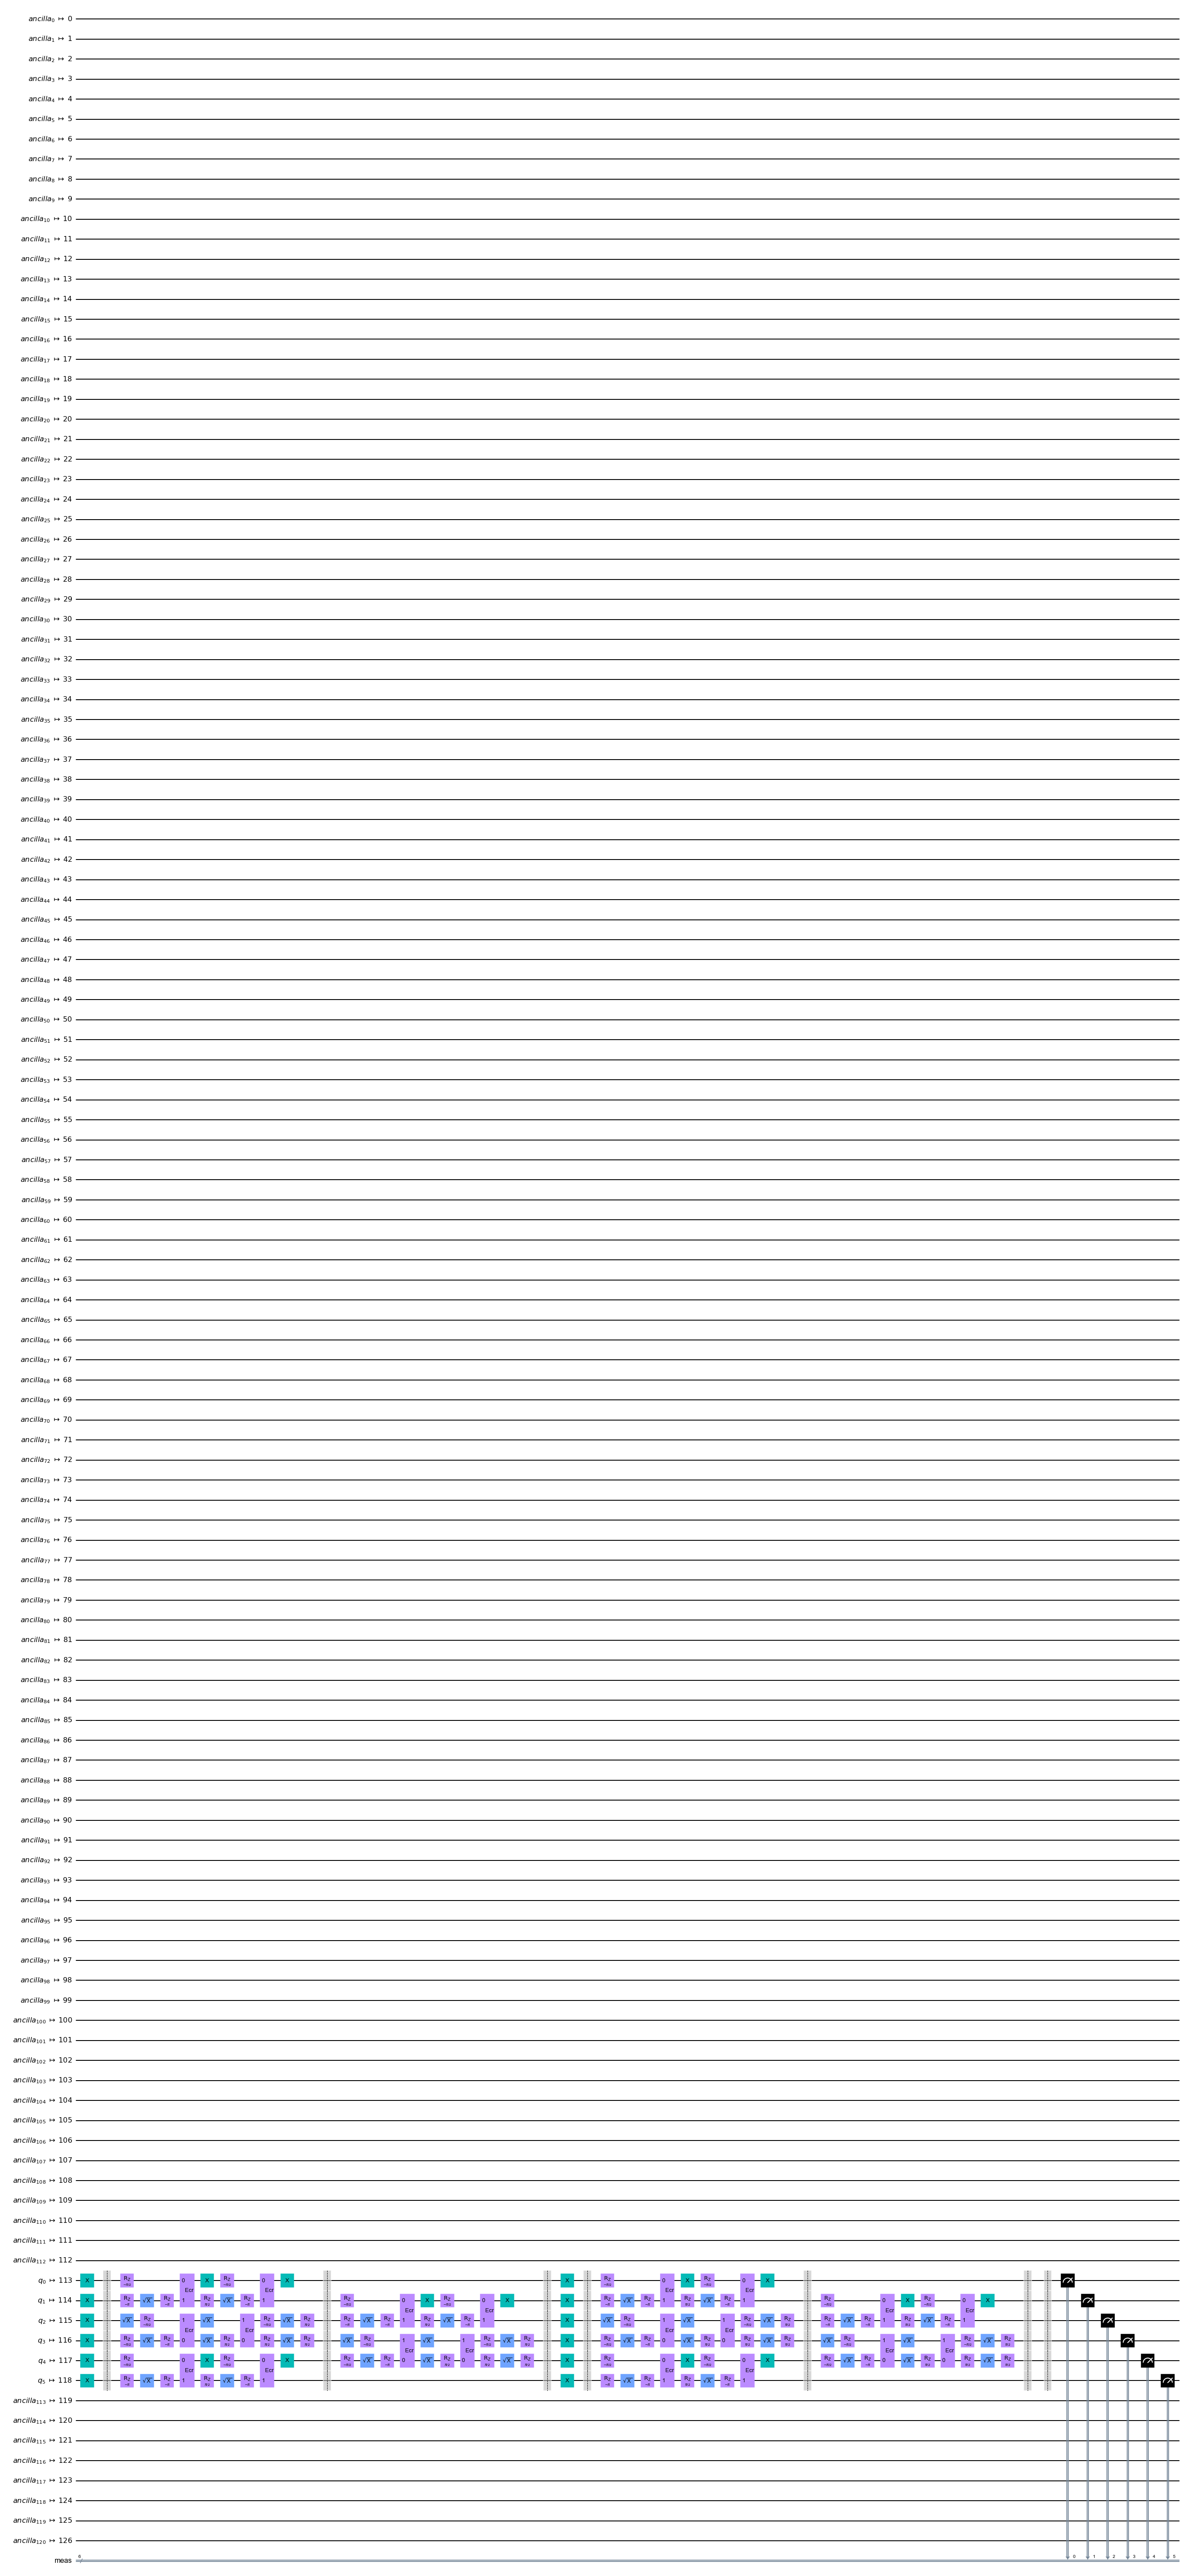

In [9]:
def construct_ising_circuit_100q(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_100q_paper()
    ops.update({'J': J})
    qc = cls.make_circs_sweep(ops, num_steps, basis)
    return qc

def construct_ising_circuit_6q(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_6q_paper()
    ops.update({'J': J})
    qc = cls.make_circs_sweep(ops, num_steps, basis)
    return qc

J = np.pi/2
basis = 'Z'
random_ising = construct_ising_circuit_6q(J, basis, 2)
trans_circuit = transpile(
    random_ising,
    backend=real_backend,
    optimization_level=1,
    # initial_layout=sherbrooke_layout,
    initial_layout=list(range(113, 119))
)
trans_circuit.draw('mpl', fold=-1)

In [10]:
def form_all_qubit_observable(observable, measurement_qubits, total_num_qubits):
    """Input observable in non-endian, output observable in endian"""
    assert len(observable) == len(measurement_qubits)
    converted_obs = list('I' * total_num_qubits)
    for qubit, basis in zip(measurement_qubits, list(observable)):
        converted_obs[qubit] = basis
    return ''.join(converted_obs)[::-1]

def get_measurement_qubits(qc, num_measured_qubit):
    measurement_qubits = []
    for measurement in range(num_measured_qubit - 1, -1, -1):
        measurement_qubits.append(qc.data[-1 - measurement][1][0].index)
    return measurement_qubits

h = np.pi
def construct_random_ising_func(num_steps, be):
    J = np.random.uniform(0, h, size=1)[0]
    basis = 'Z'
    random_ising = construct_ising_circuit_6q(J, basis, num_steps)
    trans_circuit = transpile(
        random_ising,
        backend=be,
        optimization_level=1,
        # initial_layout=sherbrooke_layout,
        initial_layout=list(range(113, 119))
    )
    return trans_circuit

In [11]:
from qiskit.transpiler.exceptions import TranspilerError
import scipy

def generate_data(generating_func, two_q_gate_depths, save_path: str, n_entries_per_file: int):
    for depth in two_q_gate_depths:
        entries = []

        for i in tqdm_notebook(range(n_entries_per_file)):
            success = False
            while not success:
                try:
                    trans_circuit = generating_func(depth)
                    success = True
                except (scipy.linalg.LinAlgError, TranspilerError, np.linalg.LinAlgError) as e:
                    print(f"Ran into an error:, {e}")

            # obs_list = ['I'*i+'Z'+'I'*(6-1-i) for i in range(6)]
            # padded_obs = [SparsePauliOp(
            #     form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 6), 127))
            #     for obs in obs_list]
            # trans_circuit.remove_final_measurements()
            # ideal_exp_vals = Estimator().run([trans_circuit]*6, padded_obs, shots=None).result().values
            # noisy_exp_vals = BackendEstimator(backend=fake_backend).run([trans_circuit]*6, padded_obs, shots=10000).result().values

            to_append = dict()
            to_append['circuit'] = trans_circuit
            # to_append['ideal_exp_vals'] = ideal_exp_vals
            # to_append['noisy_exp_vals'] = noisy_exp_vals
            entries.append(to_append)

        path = f"{save_path}/step_{depth}.pk"
        with open(path, "wb") as f:
            pickle.dump(entries, f)

# random.seed(0)
# np.random.seed(0)
# steps = list(range(15))
# generate_data(partial(construct_random_ising_func, be=real_backend), steps,
#               './data/ising_zne_hardware/6q_train', 20)

In [ ]:
# with open('./data/ising_zne_hardware/6q_train/step_8.pk', 'rb') as file:
#     loaded = pickle.load(file)
#
# trans_circuit = loaded[0]['circuit']
# trans_circuit.draw('mpl', fold=-1)

In [12]:
import os
from tqdm.notebook import tqdm
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)]
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits.append(entry['circuit'])
                # ideal_exp_vals.append(entry['ideal_exp_value'])
                # noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits #, ideal_exp_vals, noisy_exp_vals

train_circuits = load_circuits('./data/ising_zne_hardware/6q_train', '.pk')

KeyboardInterrupt: 

In [196]:
obs_list = ['I'*i+'Z'+'I'*(6-1-i) for i in range(6)]
padded_obs = [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 6), 127)) for obs in obs_list]

In [197]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options
options = Options()
options.resilience_level = 2
options.optimization_level = 0
options.resilience.noise_factors = (1, 3, 5)
options.resilience.noise_amplifier = 'CxAmplifier'
options.resilience.extrapolator = 'QuadraticExtrapolator'

service = QiskitRuntimeService()
with Session(service=service, backend="ibm_sherbrooke") as session:
    runtime_estimator = RuntimeEstimator(session=session, options=options)

    circ_to_submit = []
    for circ in train_circuits:
        circ.remove_final_measurements()
        circ_to_submit.append(circ)

    job = runtime_estimator.run(
        circuits=np.repeat(circ_to_submit, 6),
        observables=padded_obs * len(circ_to_submit)
    )

In [ ]:
def get_zne_expval_parallel(
        extrapolator,
        backend,
        noise_factors=(1, 3, 5, 7),
        amplifier=LocalFoldingAmplifier(gates_to_fold=2),
) -> float:
    ZNEEstimator = zne(runtime_estimator)
    zne_estimator = ZNEEstimator()

    zne_strategy = ZNEStrategy(
        noise_factors=noise_factors,
        noise_amplifier=amplifier,
        extrapolator=extrapolator
    )

    return zne_strategy, zne_estimator

extrapolator = PolynomialExtrapolator(degree=2)
zne_strategy, zne_estimator = get_zne_expval_parallel(extrapolator, real_backend)

In [117]:
obs_list = ['I'*i+'Z'+'I'*(100-1-i) for i in range(2)]
padded_obs = [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 100), 127)) for obs in obs_list]
trans_circuit.remove_final_measurements()
job = zne_estimator.run([trans_circuit]*2, padded_obs, shots=10000, zne_strategy=zne_strategy)

In [118]:
job_status = job.status()

In [68]:
job_status.value

'job has successfully run'

In [71]:
job.result()

/opt/anaconda3/envs/ngem/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/Users/haoranliao/Desktop/prototype-zne-main/zne/extrapolation/polynomial_extrapolator.py:149: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - RSS / TSS


EstimatorResult(values=array([0., 0.]), metadata=[{'std_error': nan, 'zne': {'noise_amplification': {'noise_amplifier': <LocalFoldingAmplifier:{'gates_to_fold': 2, 'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>, 'noise_factors': (1, 3, 5, 7), 'values': (1.0, 1.0, 1.0, 1.0), 'variance': (0.0, 0.0, 0.0, 0.0), 'shots': (10000, 10000, 10000, 10000)}, 'extrapolation': {'extrapolator': PolynomialExtrapolator(degree=2), 'coefficients': (0.0, 0.0, 0.0), 'covariance_matrix': ((nan, nan, nan), (nan, nan, nan), (nan, nan, nan)), 'residuals': (1.0, 1.0, 1.0, 1.0), 'R2': -inf}}}, {'std_error': nan, 'zne': {'noise_amplification': {'noise_amplifier': <LocalFoldingAmplifier:{'gates_to_fold': 2, 'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>, 'noise_factors': (1, 3, 5, 7), 'values': (1.0, 1.0, 1.0, 1.0), 'variance': (0.0, 0.0, 0.0, 0.0), 'shots': (10000, 10000, 10000, 10000)}, 'extrapolation': {'extr

In [21]:
estimator = Estimator()
estimator_job = estimator.run(circuits=trans_circuit, observables=padded_obs[0], shots=None)

In [22]:
job.result().values

ValueError: Maximum allowed dimension exceeded